# Assignment 7
## Group Members:
* ### Nils Dunlop, e-mail: gusdunlni@student.gu.se
* ### Francisco Alejandro Erazo Piza, e-mail: guserafr@student.gu.se

## Read the Data

In [181]:
import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt
import seaborn as sns
pd.set_option('mode.chained_assignment', None)

poll_info = pd.read_csv('poll_info.csv', delimiter='\t')
poll_report = pd.read_csv('poll_report.csv', delimiter=';')

merged_df = poll_report.merge(poll_info, left_on='Question ID', right_on='Question')

## Task 1: Analyse how many questions are correctly answered by each student.

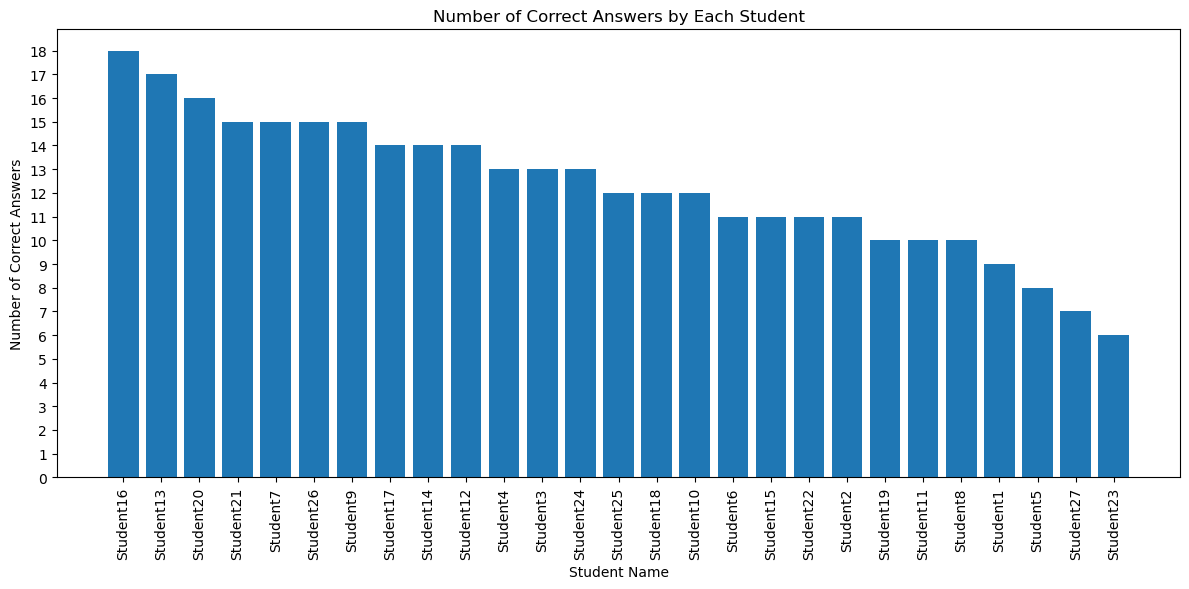

In [182]:
# Adding a column for the correct answer
merged_df['is_correct'] = merged_df['Correct Answer'] == merged_df['Student Answer']

# Group by student name and sum the number of correct answers
student_scores = merged_df.groupby('User Name')['is_correct'].sum().reset_index()
student_scores = student_scores.sort_values(by='is_correct', ascending=False)

# Plotting
plt.figure(figsize=(12,6))
plt.bar(student_scores['User Name'], student_scores['is_correct'])
plt.ylabel('Number of Correct Answers')
plt.xlabel('Student Name')
plt.xticks(rotation=90)
plt.title('Number of Correct Answers by Each Student')
plt.yticks(range(int(student_scores['is_correct'].max()) + 1)) # Setting the y-axis to integers
plt.tight_layout()
plt.show()

## Task 2: Analyse how many students answered correclty for each question

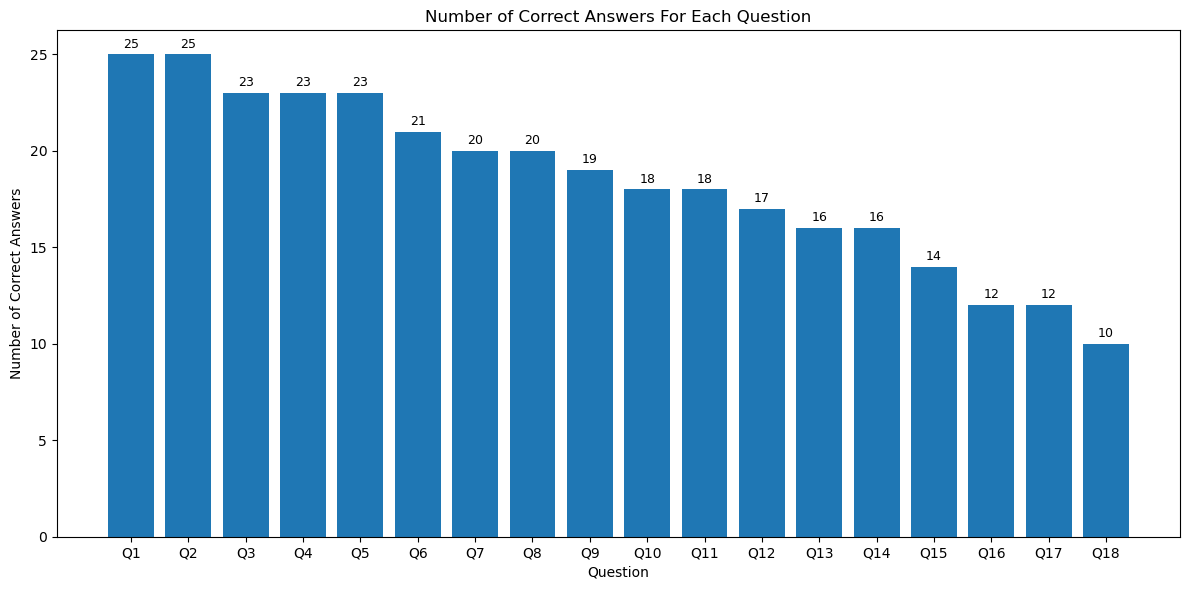

In [183]:
# Group by question and sum the number of correct answers
question_answers = merged_df.groupby('Question')['is_correct'].sum().reset_index()
question_answers = question_answers.sort_values(by='is_correct', ascending=False)

# Plotting
plt.figure(figsize=(12,6))
bars = plt.bar(range(len(question_answers)), question_answers['is_correct'])
# Loop through each bar and add the number of correct answers
for idx, bar in enumerate(bars):
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.2, int(yval), ha='center', va='bottom', fontsize=9)
custom_x_ticks = ['Q{}'.format(i) for i in range(1, 19)]
#plt.xticks(range(len(question_answers)), question_answers['Question'].values)
plt.xticks(range(len(custom_x_ticks)), custom_x_ticks)
plt.ylabel('Number of Correct Answers')
plt.xlabel('Question')
plt.title('Number of Correct Answers For Each Question')
plt.tight_layout()
plt.show()

## Task 3a: For each student, which questions(s) took the longest time for that student?

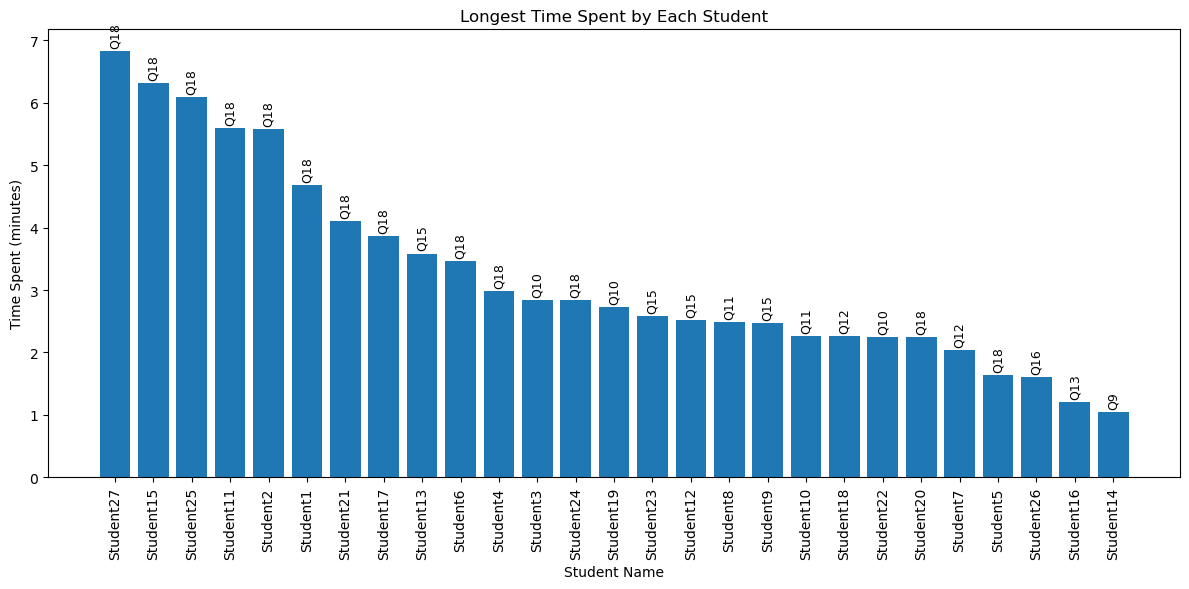

In [184]:
# Convert the time columns to datetime
merged_df['Time Launched'] = pd.to_datetime(merged_df['Time Launched'])
merged_df['Submitted Date/Time'] = pd.to_datetime(merged_df['Submitted Date/Time'])

# Calculate the time difference between the time launched and the time submitted in minutes
merged_df['Time Spent'] = (merged_df['Submitted Date/Time'] - merged_df['Time Launched'])

idx = merged_df.groupby('User Name')['Time Spent'].idxmax()

longest_times = merged_df.loc[idx]
longest_times = longest_times.sort_values(by='Time Spent', ascending=False)

# Plotting
plt.figure(figsize=(12, 6))
bars = plt.bar(longest_times.set_index('User Name')['Time Spent'].index, longest_times.set_index('User Name')['Time Spent'].dt.total_seconds()/60)
plt.ylabel('Time Spent (minutes)')
plt.xlabel('Student Name')
plt.title('Longest Time Spent by Each Student')

# Annotate each bar with the corresponding question
for bar, question in zip(bars, longest_times['Question']):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height()+0.05, f'Q{question}', ha='center', va='bottom', fontsize=9, rotation=90)

plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

## Task 3b: Which question(s) took the longest time to answer among all students?

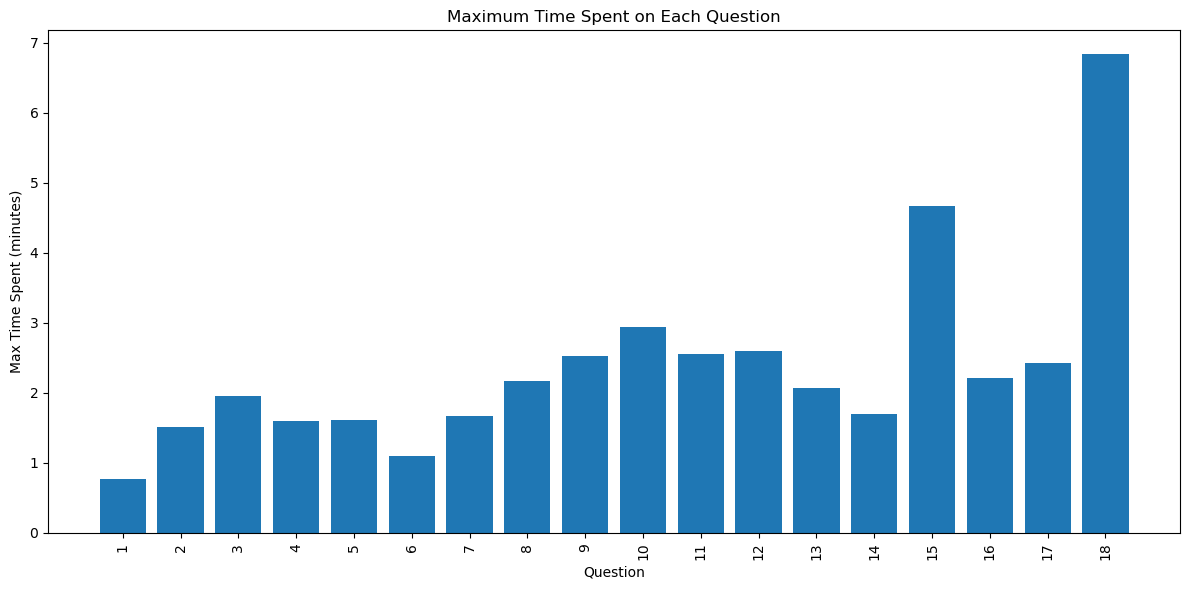

In [185]:
max_times_per_question = merged_df.groupby('Question')['Time Spent'].max()

sorted_max_times = max_times_per_question.sort_values(ascending=False)


def plot_max_avg_times(times, title, ylabel):
    plt.figure(figsize=(12, 6))
    plt.bar(times.index, times.dt.total_seconds()/60)
    plt.ylabel(ylabel)
    plt.xlabel('Question')
    plt.title(title)
    plt.xticks(ticks=times.index, labels=times.index, rotation=90)
    plt.tight_layout()
    plt.show()

plot_max_avg_times(sorted_max_times, 'Maximum Time Spent on Each Question', 'Max Time Spent (minutes)')

## Task 3c: Which question(s) had the longest average response time?

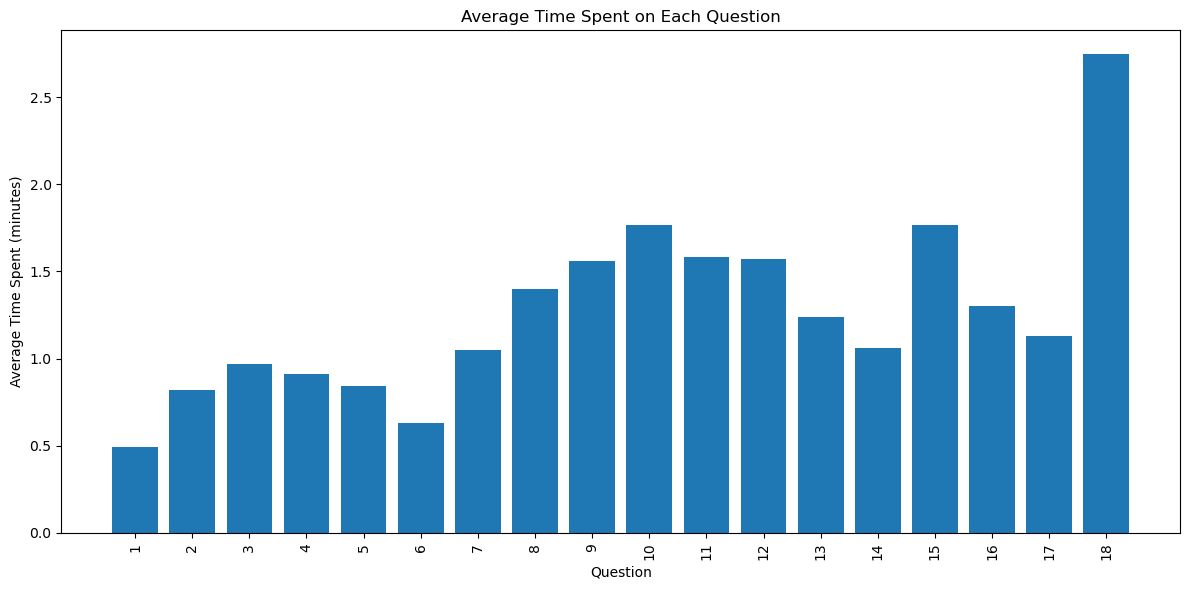

In [186]:
average_times = merged_df.groupby('Question')['Time Spent'].mean()
sorted_avg_times = average_times.sort_values(ascending=False)

plot_max_avg_times(sorted_avg_times, 'Average Time Spent on Each Question', 'Average Time Spent (minutes)')

## Task 4: Investigate whether students who took a longer time to answer perform well or not.

The correlation between the number of correct answers and total time spent is: -0.54


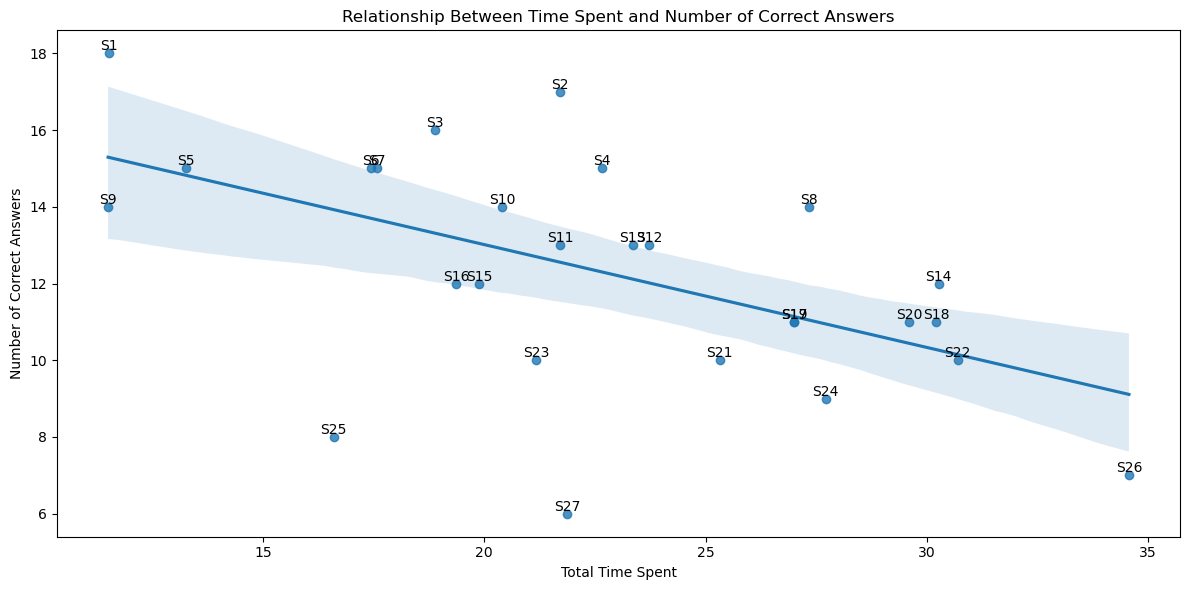

In [187]:
# Calculate the total time spent by each student
total_times = merged_df.groupby('User Name')['Time Spent'].sum()
total_times = total_times.sort_values(ascending=False)

total_times_df = total_times.reset_index()

merged_scores_times = pd.merge(student_scores, total_times_df, on='User Name')

merged_scores_times['Time Spent'] = merged_scores_times['Time Spent'].dt.total_seconds() / 60

correlation = merged_scores_times['is_correct'].corr(merged_scores_times['Time Spent'])

print(f"The correlation between the number of correct answers and total time spent is: {correlation:.2f}")

# Visualize the relationship between total time spent and number of correct answers using a scatter plot with a regression line
plt.figure(figsize=(12, 6))
sns.regplot(x='Time Spent', y='is_correct', data=merged_scores_times)

for i, row in merged_scores_times.iterrows():
    plt.text(row['Time Spent'], row['is_correct'], 'S'+str(i+1), ha='center', va='bottom')

plt.ylabel('Number of Correct Answers')
plt.xlabel('Total Time Spent')
plt.title('Relationship Between Time Spent and Number of Correct Answers')
plt.tight_layout()
plt.show()

## Task 5: Find all pairs of students who gave the same wrong answers for at least two questions.

In [188]:
# Get all the wrong answers
wrong_answers = merged_df[merged_df['is_correct'] == False]

# Get all the wrong answers for each student
wrong_answers_per_student = wrong_answers.groupby('User Name')['Question'].apply(list).reset_index()

# Get all the pairs of students who gave the same wrong answers for at least two questions
pairs = set()
for i, row in wrong_answers_per_student.iterrows():
    for j in range(i+1, len(wrong_answers_per_student)):
        row2 = wrong_answers_per_student.iloc[j]
        if len(set(row['Question']).intersection(row2['Question'])) >= 2:
            pairs.add(tuple(sorted([row['User Name'], row2['User Name']]))) # sorting to ensure (A, B) and (B, A) are treated the same

print(f"The pairs of students who gave the same wrong answers for at least two questions are: {len(pairs)}")

The pairs of students who gave the same wrong answers for at least two questions are: 209


## Task 6: Are there more interesting information one can derive from studying how long each studen response to each question that might be of interest to the teacher?

The correlation between the number of correct answers and total time spent for the students with the shortest times is: -0.54


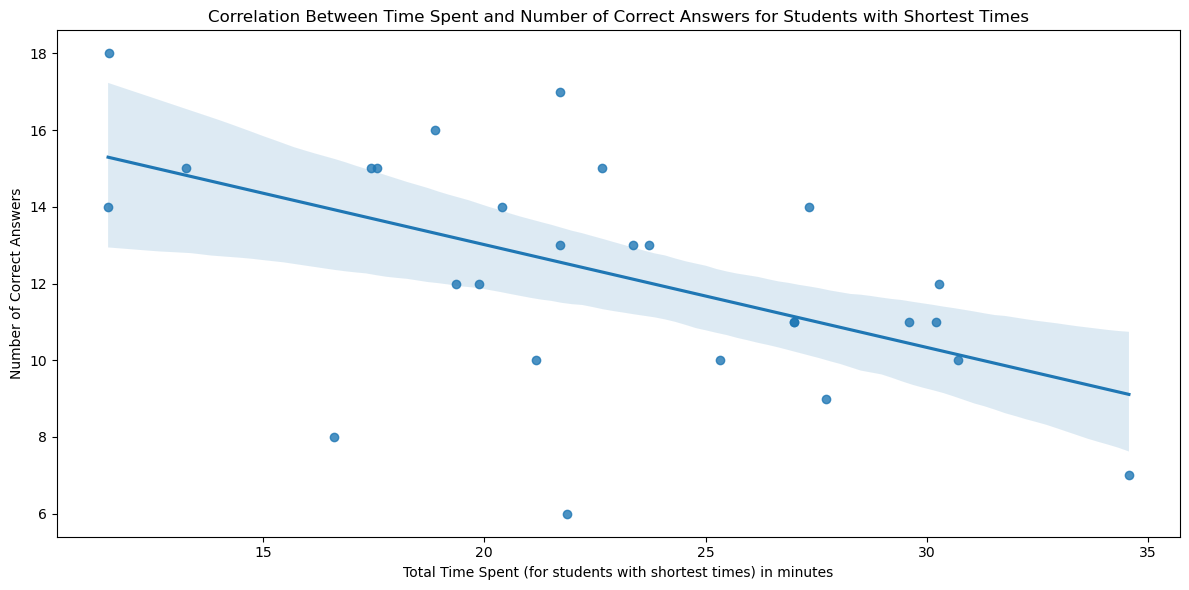

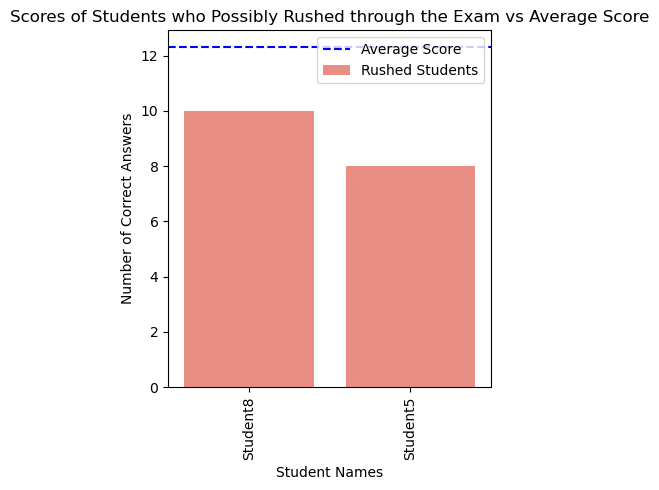

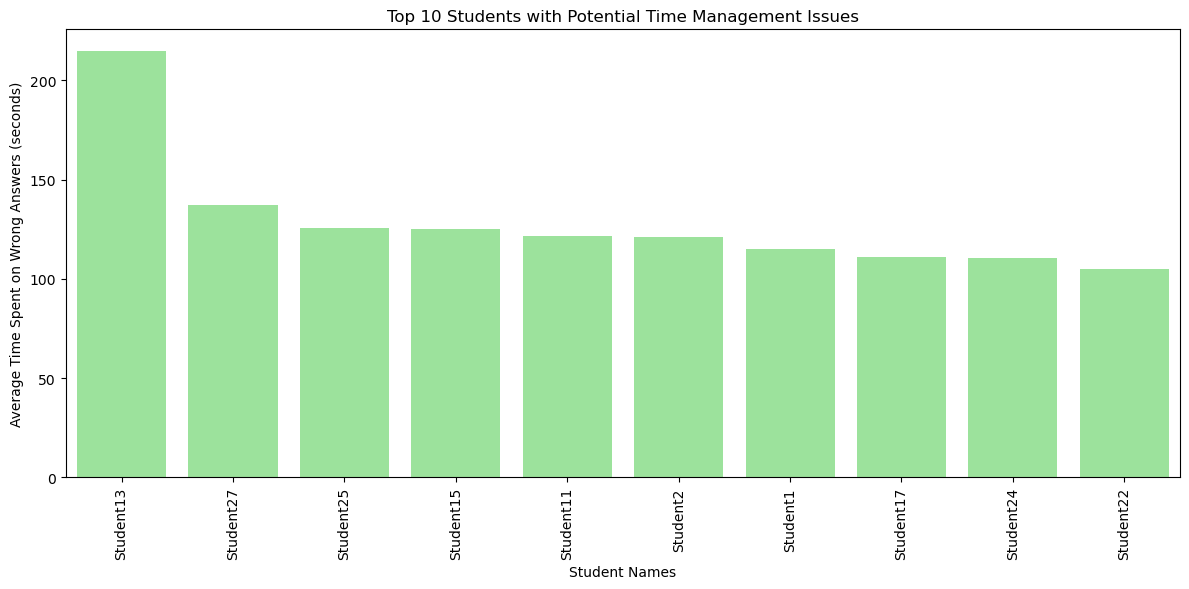

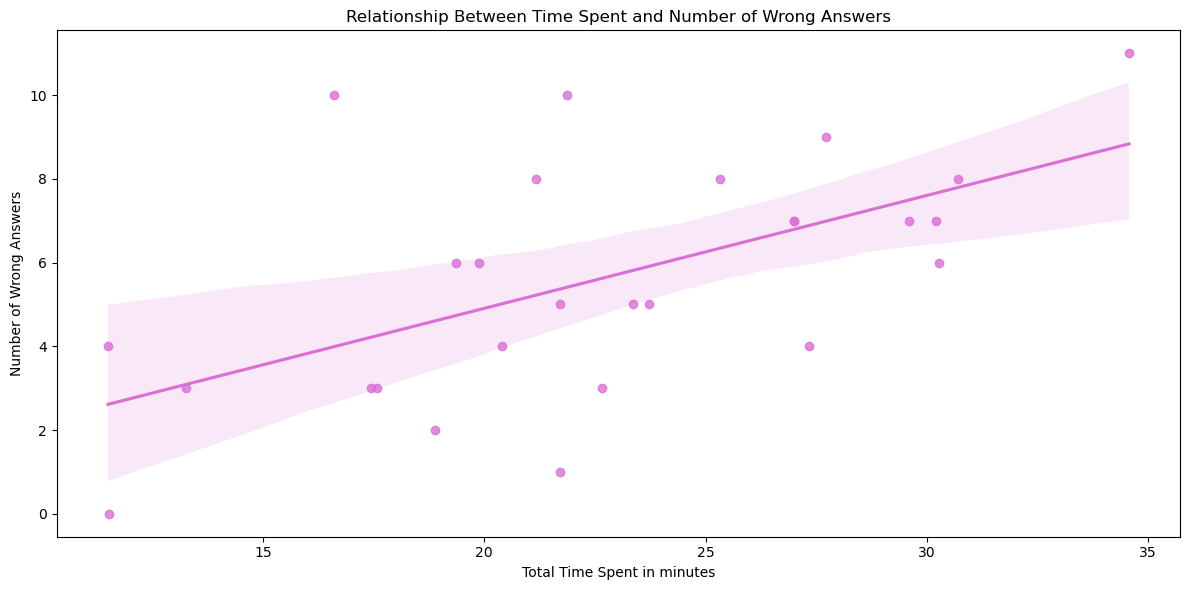

In [189]:
merged_df['Time Spent'] = (merged_df['Submitted Date/Time'] - merged_df['Time Launched']).dt.total_seconds()

# Students with the shortest time correlated to their scores
total_times = total_times.sort_values(ascending=True)
shortest_times_scores = pd.merge(total_times, student_scores, on='User Name')
shortest_times_scores['Time Spent'] = shortest_times_scores['Time Spent'].dt.total_seconds() / 60
correlation_shortest_time = shortest_times_scores['is_correct'].corr(shortest_times_scores['Time Spent'])

print(f"The correlation between the number of correct answers and total time spent for the students with the shortest times is: {correlation_shortest_time:.2f}")

# Visualize this relationship
plt.figure(figsize=(12, 6))
sns.regplot(x='Time Spent', y='is_correct', data=shortest_times_scores)
plt.ylabel('Number of Correct Answers')
plt.xlabel('Total Time Spent (for students with shortest times) in minutes')
plt.title('Correlation Between Time Spent and Number of Correct Answers for Students with Shortest Times')
plt.tight_layout()
plt.show()

# Determine the students who were rushing through the exam
merged_scores_times['Time Spent'] = merged_scores_times['Time Spent'] / 60
rushed_students = merged_scores_times[
    (merged_scores_times['Time Spent'] < merged_scores_times['Time Spent'].quantile(0.50)) &
    (merged_scores_times['is_correct'] < merged_scores_times['is_correct'].quantile(0.50))
    ]

# Visualization for students who possibly rushed through the exam
plt.figure(figsize=(4, 5))
sns.barplot(x=rushed_students['User Name'], y=rushed_students['is_correct'], color='salmon', label='Rushed Students')
plt.axhline(y=merged_scores_times['is_correct'].mean(), color='blue', linestyle='--', label='Average Score')
plt.ylabel('Number of Correct Answers')
plt.xlabel('Student Names')
plt.title('Scores of Students who Possibly Rushed through the Exam vs Average Score')
plt.legend()
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

# Time management issues
wrong_answers['Time Spent'] = wrong_answers['Time Spent'].dt.total_seconds()
long_time_wrong_answers = wrong_answers.groupby('User Name')['Time Spent'].mean().sort_values(ascending=False)
top_students_long_time_wrong = long_time_wrong_answers.head(10)

# Visualization for time management issues
plt.figure(figsize=(12, 6))
sns.barplot(x=top_students_long_time_wrong.index, y=top_students_long_time_wrong.values, color='lightgreen')
plt.ylabel('Average Time Spent on Wrong Answers (seconds)')
plt.xlabel('Student Names')
plt.title('Top 10 Students with Potential Time Management Issues')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

# Correlation with wrong answers
merged_df['is_wrong'] = ~merged_df['is_correct']
student_wrong_scores = merged_df.groupby('User Name')['is_wrong'].sum().reset_index()
merged_wrong_times = pd.merge(student_wrong_scores, total_times_df, on='User Name')
merged_wrong_times['Time Spent'] = merged_wrong_times['Time Spent'].dt.total_seconds() / 60
correlation_wrong_time = merged_wrong_times['is_wrong'].corr(merged_wrong_times['Time Spent'])

# Visualization for correlation with wrong answers
plt.figure(figsize=(12, 6))
sns.regplot(x='Time Spent', y='is_wrong', data=merged_wrong_times, color='orchid')
plt.ylabel('Number of Wrong Answers')
plt.xlabel('Total Time Spent in minutes')
plt.title('Relationship Between Time Spent and Number of Wrong Answers')
plt.tight_layout()
plt.show()

In [190]:
# Define time bins (e.g. 10-minute intervals)
time_bins = pd.date_range(start=merged_df['Time Launched'].min(), end=merged_df['Submitted Date/Time'].max(), freq='10T')

# Create a new column for the time bins
merged_df['Time Bin'] = pd.cut(merged_df['Time Launched'], bins=time_bins, labels=time_bins[:-1])

# Group the data by time bins
grouped_data = merged_df.groupby('Time Bin')

# Calculate the mean reponse time for each time bin
mean_response_time = grouped_data['Time Spent'].mean()

# Calculate the percentage of correct answers for each time bin
percentage_correct = grouped_data['is_correct'].mean() * 100


In [191]:
""" # Create a line plot for response time
plt.figure(figsize=(10, 6))
plt.plot(time_bins[:-1], mean_response_time)
plt.xlabel('Time')
plt.ylabel('Mean Response Time (seconds)')
plt.title('Mean Response Time Over Time')
plt.xticks(rotation=45)
plt.show()

# Create a line plot for the percentage of correct answers
plt.figure(figsize=(10, 6))
plt.plot(time_bins[:-1], percentage_correct)
plt.xlabel('Time')
plt.ylabel('Percentage Correct Answers')
plt.title('Percentage of Correct Answers Over Time')
plt.xticks(rotation=45)
plt.ylim(0, 100)
plt.show() """

" # Create a line plot for response time\nplt.figure(figsize=(10, 6))\nplt.plot(time_bins[:-1], mean_response_time)\nplt.xlabel('Time')\nplt.ylabel('Mean Response Time (seconds)')\nplt.title('Mean Response Time Over Time')\nplt.xticks(rotation=45)\nplt.show()\n\n# Create a line plot for the percentage of correct answers\nplt.figure(figsize=(10, 6))\nplt.plot(time_bins[:-1], percentage_correct)\nplt.xlabel('Time')\nplt.ylabel('Percentage Correct Answers')\nplt.title('Percentage of Correct Answers Over Time')\nplt.xticks(rotation=45)\nplt.ylim(0, 100)\nplt.show() "

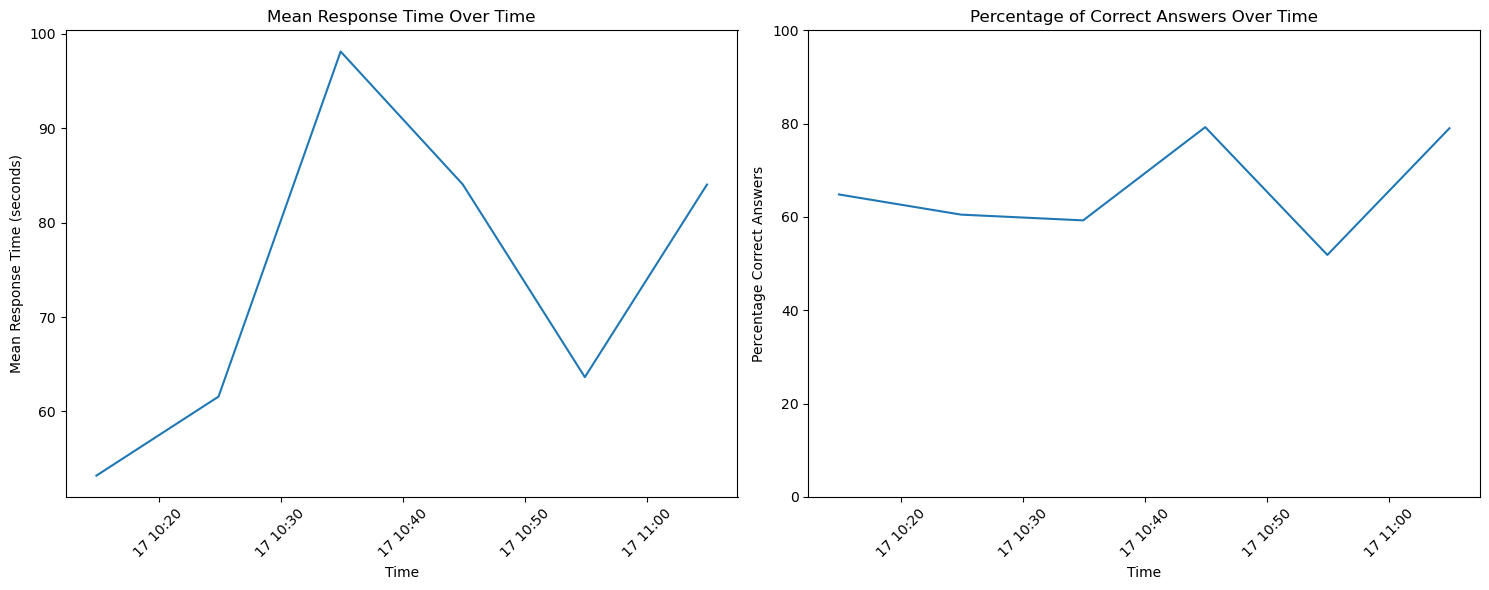

In [192]:
# Create a figure with two subplots (1 row, 2 columns)
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Plot the Mean Response Time on the first subplot
axes[0].plot(time_bins[:-1], mean_response_time)
axes[0].set_xlabel('Time')
axes[0].set_ylabel('Mean Response Time (seconds)')
axes[0].set_title('Mean Response Time Over Time')
axes[0].tick_params(axis='x', rotation=45)

# Plot the Percentage of Correct Answers on the second subplot
axes[1].plot(time_bins[:-1], percentage_correct)
axes[1].set_xlabel('Time')
axes[1].set_ylabel('Percentage Correct Answers')
axes[1].set_title('Percentage of Correct Answers Over Time')
axes[1].set_ylim(0, 100)
axes[1].tick_params(axis='x', rotation=45)

# Adjust the layout for better spacing
plt.tight_layout()

# Show the combined figure with both subplots
plt.show()